# Introduction to the WildHunt package

### Purpose of WildHunt 
The WildHunt package was designed to provide helpful functionality in the search for and spectroscopic identification of high-redshift quasars.

In this context it combines multiple tasks available in distinct python packages under one umbrella. The main tasks are:
- Matching of catalog data to off-line catalogs or on-line services using a common API.
- The download of image (cutout) data from a variety of on-line services.
- The calculation of forced photometry on downloaded (cutout) images.
- The creating of finding charts for observations, including the automatic search for off-set stars.

### Imports

In [24]:
from wildhunt import catalog


### 1. The Catalog class
WildHunt implements the "Catalog" class as a base class for most of its tasks. Catalogs in WildHunt are stored as 
Dask DataFrames, with three minimum columns per sources: 
- A unique identifier (ID, id_colname)
- Right Ascension (RA, ra_colname)
- Declination (Dec, dec_colname)

Catalogs can be build from a range of filetypes that commonly store tabular data (e.g. csv, fits, parquet, hdf5,...).
 If exceeding a limit of 1GB, the Dask DataFrame is partitioned into 100MB chunks. These limits are currently 
 implement to not overwhelm weaker machines and allow the efficient use of multiprocessing.

#### Example of instantiating a Catalog instance
A range of example catalogs are found in the examples/data directory. Those include:
- pselqs_quasars.csv : The Pan-STARRS 1 ELQS quasar catalog (Schindler+2019) of 592 sources at Decl. > -30 deg.
- UKIDSS_sources.csv : ~100 quasar candidates selected based on UKIDSS photometry. This was a dataset used for the 
first tests of WildHunt and includes obviously bad quasar candidates. The coverage of the sources is limited to the 
UKIDSS area.
- UKIDSS_sources.hdf5 : The same dataset as above, but stored in the hdf5 format.
- Euclid_sources.csv: Two sources for the development of the Euclid cutout image download. This is not an adequate 
dataset for testing the full WildHunt capabilities.

Here, we will select the pselqs_quasars.csv catalog for demonstration purposes.

In [25]:

# Defining the main initialisation inputs
filename = 'data/pselqs_quasars.csv'
ra_colname = 'ps_ra'
dec_colname = 'ps_dec'
id_colname = 'wise_designation'

# Instantiating the Catalog 
cat = catalog.Catalog('example', ra_column_name=ra_colname,
                              dec_column_name=dec_colname,
                              id_column_name=id_colname,
                              datapath=filename)

[INFO]    :: Initializing catalog dataframe (dask dataframe)
[INFO]    :: Catalog dataframe initialized.
[INFO]    :: Set dask temporary directory to ./dask_temp


The main Dask Dataframe is accessible via the "df" attribute of the Catalog instance. 

In [26]:
# Displaying the first few rows of the catalog
cat.df.head()

,wise_designation,ps_ra,ps_dec
0,J000322.94-260318.3,0.84564,-26.05508
1,J000342.56+085936.0,0.92737,8.99336
2,J000428.62+352029.0,1.11926,35.34140
3,J001553.15+292721.4,3.97145,29.45595
4,J002027.08-184400.8,5.11284,-18.73360


### 2. On-line catalog matching 
The WildHunt package provides a range of on-line services for catalog matching. These technically include all the 
data acessible via the NOIRLAB datalab as well as the python astroquery package. The functionality for the on-line 
cross-match is implemented in the "online_cross_match" method of the Catalog class.

In [27]:
help(cat.online_cross_match)

Help on method online_cross_match in module wildhunt.catalog:

online_cross_match(survey='DELS', columns='default', match_distance=3, output_dir=None, astro_datalab_table=None, astroquery_service=None, astroquery_catalog=None, astroquery_dr=None, datalab_logout=True) method of wildhunt.catalog.Catalog instance
    Positional cross-match to online catalogs with a maximum match
    distance of match_distance (in arcseconds).
    
    A number of survey presets can be selected with the "survey" keyword
    argument:
        - DELS: Dark Energy Legacy Survey: DR9 Tractor
        table (ls_dr9.tractor)
        - UNWISE: The UNWISE catalog (unwise_dr1.object)
        - CATWISE: The CatWISE 2020 catalog (catwise2020.main)
        - UKIDSSDR11LAS: The UKIDSS LAS DR11 catalog
    
    The columns keyword argument (default: 'default') can be used to
    retrieve a subset of the available columns from the online catalog.
    This option is only available for the astro datalab cross-matches of
   

Generally, matching with the NOIRLAB datalab requires the knowledge of table name in the datalab, e.g., "ls_dr9.tractor", supplied with 
the astro_datalab_table keyword. 

The use of the astroquery service requires the specification of the astroquery service (e.g, 'vsa'), the 
astroquery catalog (e.g., 'VHS'), and the astroquery data release (e.g, 'VHSDR6'). 

We have implemented some presets for on-line catalog stored in the widhunt.catalog_defaults module.

In [28]:
from wildhunt.surveys import catalog_defaults

for key in catalog_defaults.catalog_presets:
    print(key)
    print(catalog_defaults.catalog_presets[key]['service'])
    print(catalog_defaults.catalog_presets[key]['table'])
    print('\n')


DELSDR10
datalab
ls_dr10.tractor


DELSDR9
datalab
ls_dr9.tractor


UNWISE
datalab
unwise_dr1.object


CATWISE
datalab
catwise2020.main


UKIDSSDR11LAS
astroquery
ukidssdr11las


VIKINGDR5
astroquery
vikingdr5




The full information for the astroquery tables is stored in wildhunt.catalog_queries.

In [29]:
from wildhunt import catalog_queries
print(catalog_queries.astroquery_dict.keys())

dict_keys(['tmass', 'nomad', 'vhsdr6', 'ukidssdr11las', 'vikingdr5'])


#### 2.1 Example of on-line cross-match with the NOIRLAB datalab

In [30]:
merged = cat.online_cross_match(survey='DELSDR10',
                       output_dir='./catalogs')


[INFO]    :: Starting online cross match
[INFO]    :: Specified survey: DELSDR10 
[INFO]    :: was found in the catalog presets.
[INFO]    :: Using service: datalab
[INFO]    :: Using table: ls_dr10.tractor
[INFO]    :: Using default columns
[INFO]    :: Log in to NOIRLAB Astro Data Lab
[INFO]    :: Astro Data Lab USER: jtschindler
[INFO]    :: Astro Data Lab TABLES: output
test
upload
wild_upload

[INFO]    :: Beginning crossmatch on partition 0
[INFO]    :: Uploading dataframe to Astro Data Lab
[INFO]    :: Upload status: OK
[INFO]    :: Set dask temporary directory to ./dask_temp
[INFO]    :: Downloaded cross match 0 to temporary folder
[INFO]    :: Log out of NOIRLAB Astro Data Lab - Status: OK
[INFO]    :: Creating cross-matched dataframe.
[INFO]    :: Set dask temporary directory to ./dask_temp
[INFO]    :: Saving cross-matched dataframe to ./catalogs
[INFO]    :: Saved catalog to ./catalogs/example_x_ls_dr10_tractor
[INFO]    :: Removing temporary folder (wild_temp)


In [34]:
merged.df.head()

,wise_designation,ps_ra,ps_dec,source_id,source_ra,source_dec,objid,ls_id,ra,dec,...,snr_z,snr_w1,snr_w2,snr_w3,snr_w4,wisemask_w1,wisemask_w2,type,ebv,dist_arcsec
0,J000322.94-260318.3,0.84564,-26.05508,J000322.94-260318.3,0.84564,-26.05508,396.0,1.099531e+16,0.845639,-26.055084,...,858.16990,247.82167,115.515450,19.779705,6.216882,0.0,0.0,PSF,0.014987,0.014047
1,J000342.56+085936.0,0.92737,8.99336,J000342.56+085936.0,0.92737,8.99336,2904.0,1.099552e+16,0.927374,8.993356,...,562.51587,124.50103,62.057842,7.431559,1.209537,0.0,0.0,PSF,0.076856,0.020781
2,J000428.62+352029.0,1.11926,35.34140,J000428.62+352029.0,1.11926,35.34140,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN
3,J001553.15+292721.4,3.97145,29.45595,J001553.15+292721.4,3.97145,29.45595,4031.0,1.099563e+16,3.971450,29.455952,...,352.37378,142.62622,78.834274,13.417245,0.558960,0.0,0.0,PSF,0.036643,0.008049
4,J002027.08-184400.8,5.11284,-18.73360,J002027.08-184400.8,5.11284,-18.73360,1945.0,1.099535e+16,5.112841,-18.733602,...,456.91718,112.10234,48.479137,8.374552,-0.998324,0.0,0.0,PSF,0.026647,0.009213


Great, we got the matched catalog, but where do all of these columns come from. They were actually specified in 
wildhunt.catalog_presets. We can alternative supply the list of columns we want to cross-match directly to the 
online_cross_match function.

#### 2.2 Example of on-line cross-match with the astroquery service

In [35]:
#merged = cat.online_cross_match(survey='UKIDSSDR11LAS',
#                                 output_dir='./catalogs')

In [36]:
# merged.df.head()

## 3. Download of (cutout) images

Downloading (cutout) images needs special information on the on-line services that allow these. As the interface to 
the individual on-line services is not coherent, we have developed the ImagingSurvey class within the wildhunt
.surveys folder. In order to allow for automated image downloads, the specific ImagingSurvey child class needs to be 
implemented. At present we have implemented classes that provide access to imaging data from:
- Pan-Starrs 1
- Legacy Surveys (includes a range of surveys)
- LOFAR LoTSSDR2 (public data)
- VSA/WSA services (includes VHS, UKIDSS, etc.)
- unWISE

and 

- Euclid (with strong caveats)

In order to download images from one of those services, we use the get_survey_images method of the Catalog class. 
This method requires the use of a survey dictionary argument (survey_dict), which specifies the survey, the bands, 
and the field of view.
The retrieve_survey function in the catalog module provides a list of available surveys.

In [37]:
from wildhunt.catalog import retrieve_survey
help(retrieve_survey)

Help on function retrieve_survey in module wildhunt.catalog:

retrieve_survey(survey_name, bands, fov, verbosity=1)
    Retrieve survey class according to the survey name.
    
    This function instantiates the appropriate survey class for the given
    survey name and filter bands. The survey class is then returned.
    
    The currently available surveys are:
    PS1, VHS, VVV, VMC, VIK, VID, UKI, UHS, DELS, WISE, LOTSSDR2, Euclid
    
    :param survey_name: Name of the imaging survey to download images from.
    :type survey_name: str
    :param bands: list of filter bands to download images for in the given
     survey.
    :type bands: list
    :param fov: Field of view in arcseconds for image downloads from the
     imaging survey(s).
    :type fov: float
    :param verbosity: Level of verbose output (default=1)
    :type verbosity: int
    :return: Imaging survey class
    :rtype: wildhunt.surveys.imagingsurvey.ImagingSurvey



In absence of a more intelligent implementation, users have to read the function to understand how to provide the 
correct survey names.

In [38]:
import pandas as pd 
from wildhunt import catalog 
# Let us first use a subsample of the full pselqs quasar catalog.
filename = 'data/pselqs_quasars.csv'
ra_colname = 'ps_ra'
dec_colname = 'ps_dec'
id_colname = 'wise_designation'

df = pd.read_csv(filename)

subsample = df.query('ps_dec > 30').sample(10)

# Instantiating the Catalog 
cat = catalog.Catalog('example', ra_column_name=ra_colname,
                              dec_column_name=dec_colname,
                              id_column_name=id_colname,
                              table_data=subsample)



[INFO]    :: Set dask temporary directory to ./dask_temp


In [39]:
survey_dict = [
    {'survey': 'PS1', 'bands': ['g', 'r', 'i', 'z', 'y'], 'fov':50},
     # {'survey': 'UKIDSSDR11PLUSLAS', 'bands': ['J'],
     #  'fov':120},
    {'survey': 'DELSDR10', 'bands': ['z'], 'fov': 120},
    {'survey': 'allWISE', 'bands': ['3', '4'], 'fov': 120},
    {'survey': 'VHS', 'bands': ['J', 'H', 'Ks'], 'fov': 120},
    {'survey': 'LoTSSDR2', 'bands': ['150MHz'], 'fov': 120}
]

cat.get_survey_images('./demo_cutouts',  survey_dict, n_jobs=3)


[INFO]    :: All images for source J154446.34+412035.70 already exist. Source is removed from source table.
[INFO]    :: Image J000428.62+352029.04_PS1_g_fov50 already exists and is removed from download.
[INFO]    :: Download of J131105.52+510038.12_PS1_g_fov50 to ./demo_cutouts completed
[INFO]    :: Download of J003811.08+364003.90_PS1_g_fov50 to ./demo_cutouts completed
[INFO]    :: Download of J000428.62+352029.04_PS1_i_fov50 to ./demo_cutouts completed
[INFO]    :: Download of J142123.98+463317.96_PS1_g_fov50 to ./demo_cutouts completed
[INFO]    :: Download of J003811.08+364003.90_PS1_i_fov50 to ./demo_cutouts completed
[INFO]    :: Download of J105714.82+440323.83_PS1_g_fov50 to ./demo_cutouts completed
[INFO]    :: Download of J105714.82+440323.83_PS1_i_fov50 to ./demo_cutouts completed
[INFO]    :: Download of J155600.11+401645.41_PS1_g_fov50 to ./demo_cutouts completed
[INFO]    :: Download of J122343.17+503753.40_PS1_g_fov50 to ./demo_cutouts completed
[INFO]    :: Download

Empty DataFrame
Columns: [image_name, url]
Index: []


[INFO]    :: End of sleep
[INFO]    :: All images for source J154446.34+412035.70 already exist. Source is removed from source table.
[INFO]    :: Download of J003811.08+364003.90_LoTSSDR2_150MHz_fov120 to ./demo_cutouts completed
[INFO]    :: Download of J105714.82+440323.83_LoTSSDR2_150MHz_fov120 to ./demo_cutouts completed
[INFO]    :: Download of J000428.62+352029.04_LoTSSDR2_150MHz_fov120 to ./demo_cutouts completed
[INFO]    :: Download of J124615.09+713923.58_LoTSSDR2_150MHz_fov120 to ./demo_cutouts completed
[INFO]    :: Download of J122343.17+503753.40_LoTSSDR2_150MHz_fov120 to ./demo_cutouts completed
[INFO]    :: Download of J131105.52+510038.12_LoTSSDR2_150MHz_fov120 to ./demo_cutouts completed
[INFO]    :: Download of J142123.98+463317.96_LoTSSDR2_150MHz_fov120 to ./demo_cutouts completed
[INFO]    :: Download of J173003.67+484630.76_LoTSSDR2_150MHz_fov120 to ./demo_cutouts completed
[INFO]    :: Download of J155600.11+401645.41_LoTSSDR2_150MHz_fov120 to ./demo_cutouts com

Let us display a few of the image cutouts. For this task we can use the WildHunt SurveyImage class.

[INFO]    :: Trying to open from image directory
[INFO]    :: Opened ./demo_cutouts/J122343.17+503753.40_PS1_g_fov50.fits with a fov of 9999999 arcseconds
[INFO]    :: Determining color scale limits by sigma clipping.


['./demo_cutouts/J122343.17+503753.40_PS1_g_fov50.fits']


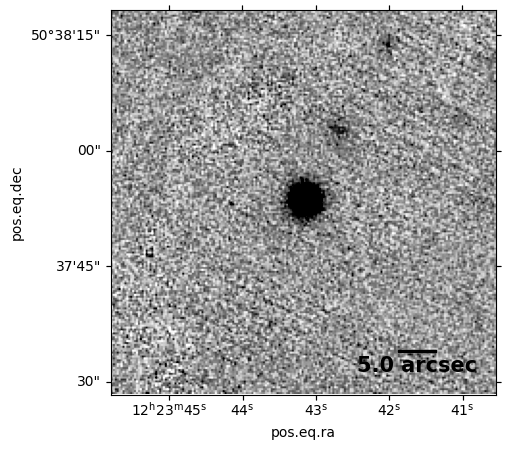

In [40]:
from wildhunt import image

ra = cat.df[ra_colname].values.compute()[3]
dec = cat.df[dec_colname].values.compute()[3]
ids = cat.df[id_colname].values.compute()[3]
min_fov = 20
image_dir = './demo_cutouts'

img = image.SurveyImage(ra, dec, 'PS1', 'g', image_dir, min_fov)
img.show(color_map='Greys')


['./demo_cutouts/J122343.17+503753.40_allWISE_3_fov120.fits']


[INFO]    :: Trying to open from image directory
[INFO]    :: Opened ./demo_cutouts/J122343.17+503753.40_allWISE_3_fov120.fits with a fov of 9999999 arcseconds
[INFO]    :: Determining color scale limits by sigma clipping.


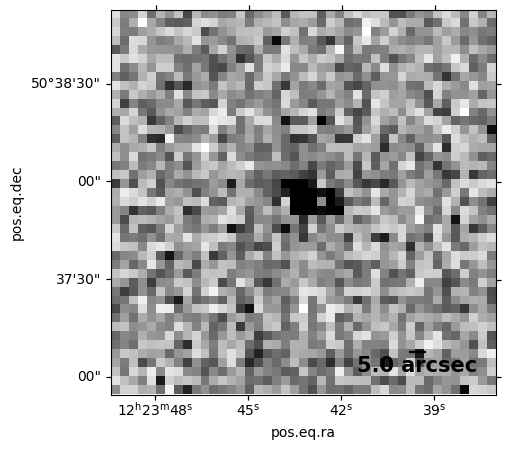

In [41]:
img = image.SurveyImage(ra, dec, 'allWISE', '3', image_dir, min_fov)
img.show(color_map='Greys')

[INFO]    :: Trying to open from image directory
[INFO]    :: Opened ./demo_cutouts/J122343.17+503753.40_DELSDR10_z_fov120.fits with a fov of 9999999 arcseconds
[INFO]    :: Determining color scale limits by sigma clipping.


['./demo_cutouts/J122343.17+503753.40_DELSDR10_z_fov120.fits']


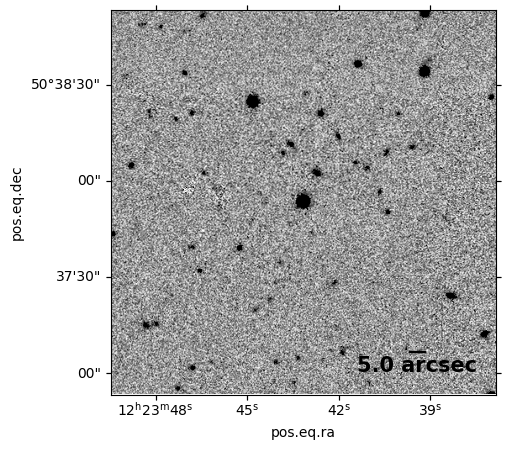

In [42]:

img = image.SurveyImage(ra, dec, 'DELSDR10', 'z', image_dir, min_fov)
img.show(color_map='Greys')


['./demo_cutouts/J122343.17+503753.40_LoTSSDR2_150MHz_fov120.fits']


[INFO]    :: Trying to open from image directory
[INFO]    :: Opened ./demo_cutouts/J122343.17+503753.40_LoTSSDR2_150MHz_fov120.fits with a fov of 9999999 arcseconds
[INFO]    :: Determining color scale limits by sigma clipping.


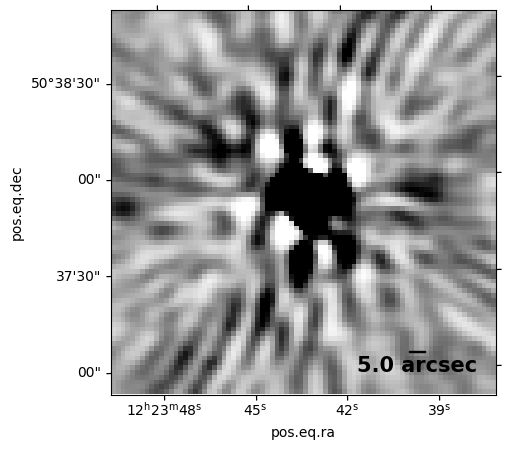

In [43]:
img = image.SurveyImage(ra, dec, 'LoTSSDR2', '150MHz', image_dir, min_fov)
img.show(color_map='Greys')


## 4. Finding chart creation

[INFO]    :: Returning generated cutout
[INFO]    :: Determining color scale limits by zscale.


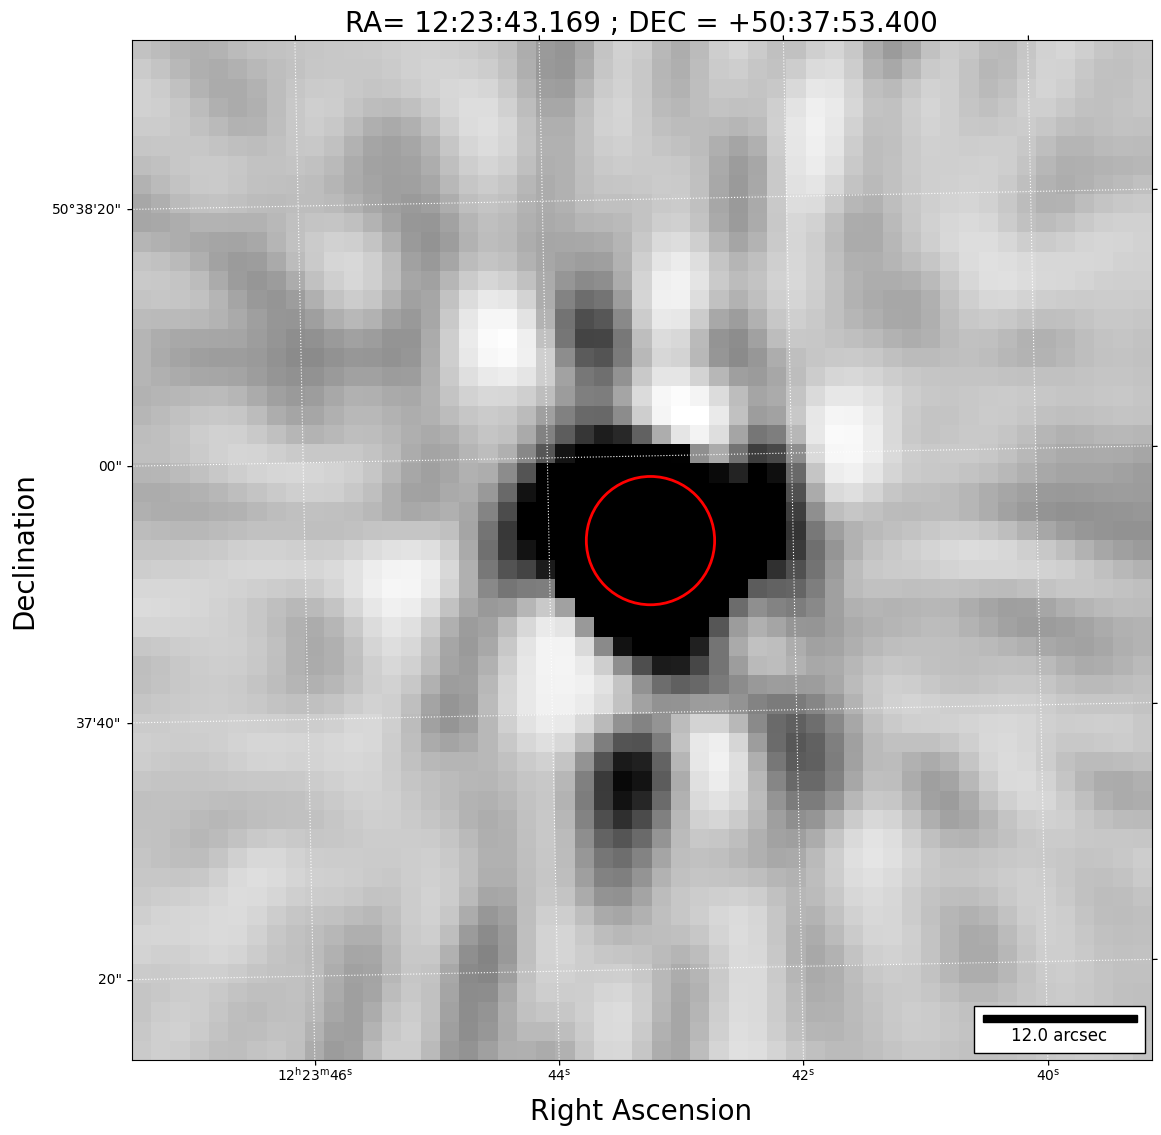

In [44]:
import matplotlib.pyplot as plt
img.finding_chart(80)
plt.show()

## 5. Euclid cutout image download

In [45]:
euclid_cat = catalog.Catalog('example', 'RA', 'DEC','Name',
                          datapath='./data/Euclid_sources.csv')

survey_dict = [
    {'survey': 'Euclid', 'bands': ['VIS', 'J', 'H'], 'fov' : 200},
]

euclid_cat.get_survey_images('./demo_cutouts',  survey_dict, n_jobs=3)

[INFO]    :: Initializing catalog dataframe (dask dataframe)
[INFO]    :: Catalog dataframe initialized.
[INFO]    :: Set dask temporary directory to ./dask_temp
/Users/jtschindler/Software/miniconda3/envs/wildhunt/lib/python3.9/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host 'easotf.esac.esa.int'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/jtschindler/Software/miniconda3/envs/wildhunt/lib/python3.9/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host 'easotf.esac.esa.int'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
[INFO]    :: Log in to the Euclid OTF archive successful!
[WARNING] :: Multiprocessing download is currently not working for E

In [46]:
euclid_cat.df.head()

,Name,RA,DEC
0,RandomGalaxy,149.784875,2.067392
1,RandomPointing,79.651702,-51.935266


[INFO]    :: Trying to open from image directory
[INFO]    :: Opened ./demo_cutouts/J051836.41-515606.96_Euclid_NIR_J_fov200.fits with a fov of 9999999 arcseconds


['./demo_cutouts/J051836.41-515606.96_Euclid_NIR_J_fov100.fits', './demo_cutouts/J051836.41-515606.96_Euclid_NIR_J_fov200.fits']


[INFO]    :: Determining color scale limits by sigma clipping.


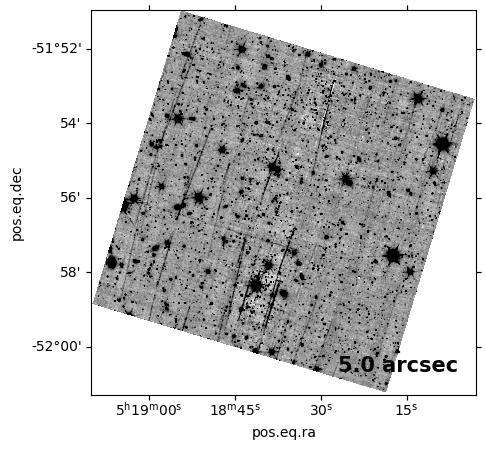

In [47]:

img = image.SurveyImage(79.6517025, -51.935266, 'Euclid', 'NIR_J', './demo_cutouts', 200)
img.show(color_map='Greys')

[INFO]    :: Returning generated cutout
[INFO]    :: Determining color scale limits by zscale.


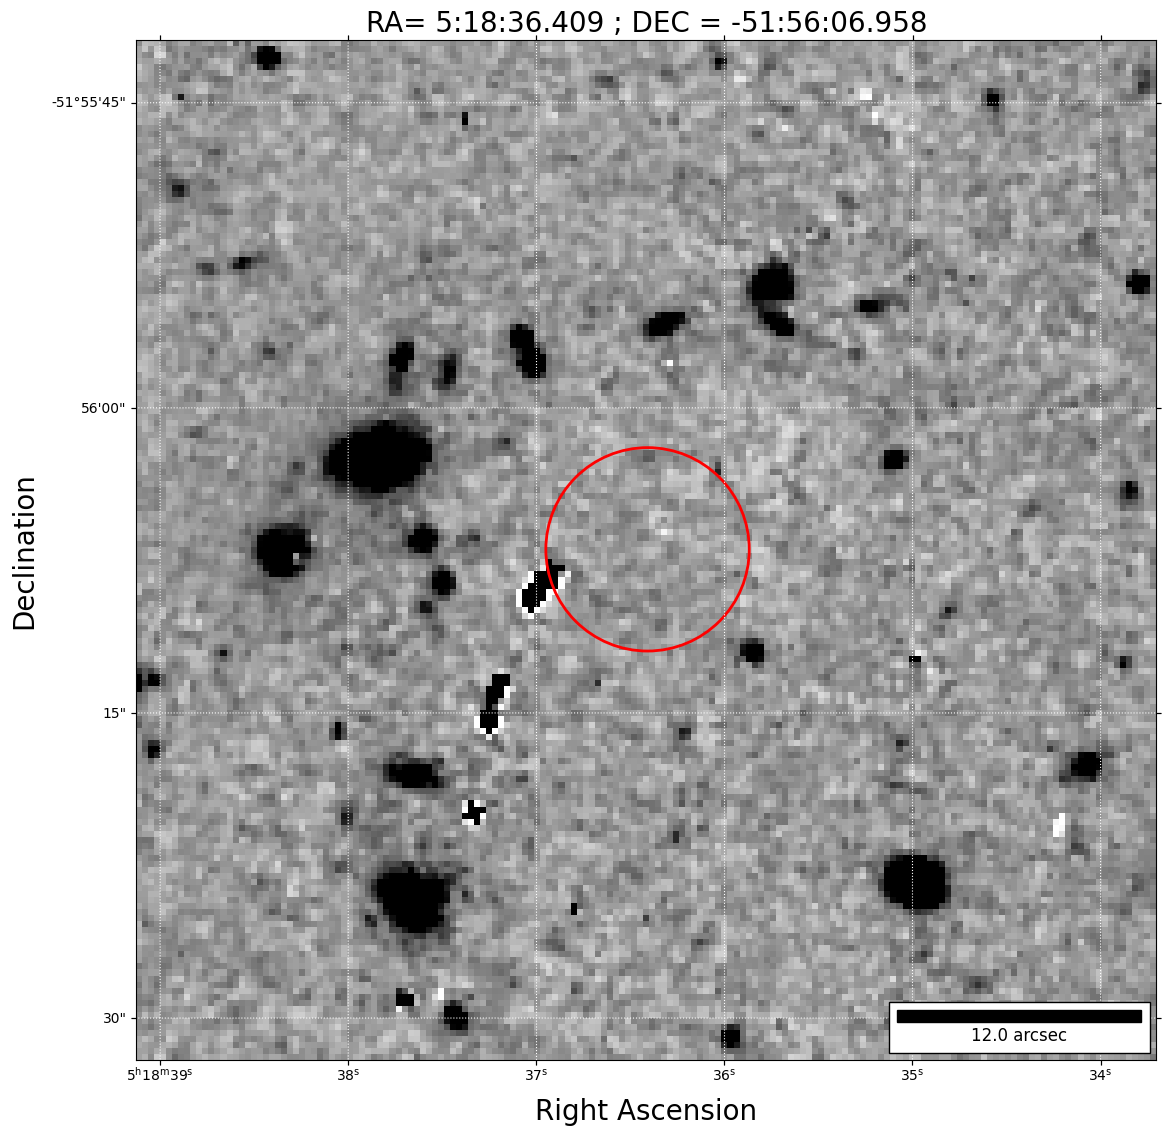

In [48]:
img.finding_chart(50)
plt.show()